In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)
print(fontprop)

plt.rc('font', family='NanumGothic')

sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:file=/usr/share/fonts/truetype/nanum/NanumGothic.ttf:size=10.0


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/GPS_data.csv', encoding='euc-kr')
df.tail()

,운송기사 코드,시간,이동 X좌표,이동 Y좌표,속도(km/s),센터 X좌표,센터 Y좌표,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
31739,O,2023-05-05 14:28,127.881519,37.662816,87,127.890398,37.313272,NaN,NaN,NaN,NaN,NaN,NaN
31740,O,2023-05-05 14:29,127.874470,37.673833,83,127.890398,37.313272,NaN,NaN,NaN,NaN,NaN,NaN
31741,O,2023-05-05 14:30,127.864079,37.683687,36,127.890398,37.313272,NaN,NaN,NaN,NaN,NaN,NaN
31742,O,2023-05-05 14:31,127.861946,37.688009,0,127.890398,37.313272,NaN,NaN,NaN,NaN,NaN,NaN
31743,O,2023-05-05 14:32,127.863405,37.688561,9,127.890398,37.313272,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Remove Unnamed rows
df_cleaned = df.dropna(axis=1, how='all')

# Calculate the quartiles to remove outliers
Q1_x = df_cleaned['이동 X좌표'].quantile(0.25)
Q3_x = df_cleaned['이동 X좌표'].quantile(0.75)
IQR_x = Q3_x - Q1_x
lower_bound_x = Q1_x - 1.5 * IQR_x
upper_bound_x = Q3_x + 1.5 * IQR_x

Q1_y = df_cleaned['이동 Y좌표'].quantile(0.25)
Q3_y = df_cleaned['이동 Y좌표'].quantile(0.75)
IQR_y = Q3_y - Q1_y
lower_bound_y = Q1_y - 1.5 * IQR_y
upper_bound_y = Q3_y + 1.5 * IQR_y

# Remove Outliers
df_filtered = df_cleaned[(df_cleaned['이동 X좌표'] >= lower_bound_x) &
                         (df_cleaned['이동 X좌표'] <= upper_bound_x) &
                         (df_cleaned['이동 Y좌표'] >= lower_bound_y) &
                         (df_cleaned['이동 Y좌표'] <= upper_bound_y)]

# Check the data
df_filtered.head()

,운송기사 코드,시간,이동 X좌표,이동 Y좌표,속도(km/s),센터 X좌표,센터 Y좌표
0,A,2023-05-06 8:50,127.917573,37.003004,0,127.890398,37.313272
1,A,2023-05-06 8:51,127.917573,37.003004,0,127.890398,37.313272
2,A,2023-05-06 8:52,127.917571,37.003022,0,127.890398,37.313272
3,A,2023-05-06 8:53,127.917571,37.003022,0,127.890398,37.313272
4,A,2023-05-06 19:08,127.775105,37.105491,0,127.890398,37.313272


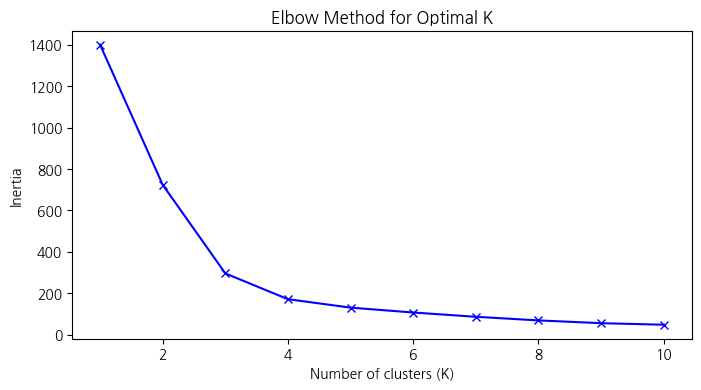

In [ ]:
'''
K-Means 군집분석으로 차량이 자주 머무는 위치 파악.
'''

from sklearn.cluster import KMeans

# Choosing coordinates for clustering
coords = df_filtered[['이동 X좌표', '이동 Y좌표']]

# Elbow Method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(coords)
    inertia.append(kmeans.inertia_)

# Visualize the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [ ]:
'''
Based on the elbow method, I chose to have 3 clusters
'''

optimal_k = 3  # 3 선택.

# Train the model
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(coords)

# Add the cluster column to the dataframe
df_filtered['Cluster'] = kmeans.labels_

# Check the cluster centroids
cluster_centers = kmeans.cluster_centers_
print(cluster_centers)

[[127.9193742   37.3554773 ]
 [128.18263091  37.13454969]
 [127.78806564  37.81196153]]


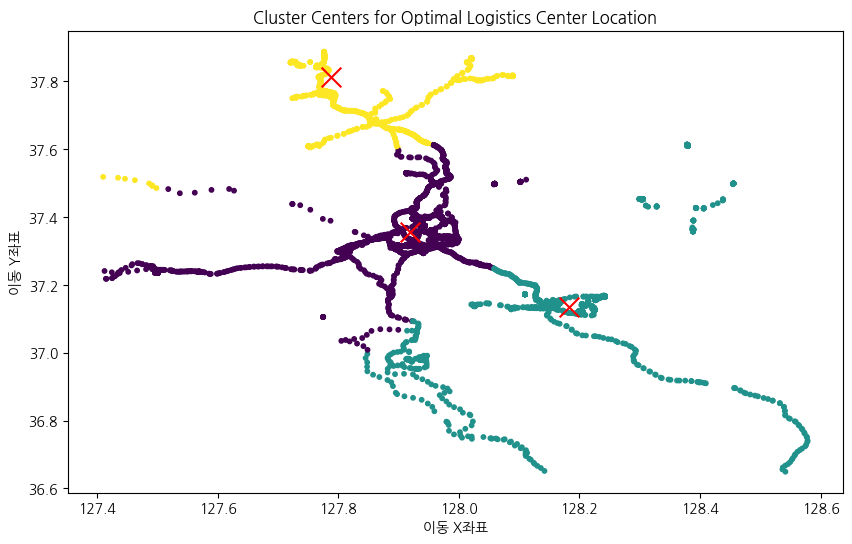

Cluster 1 Center: X좌표 = 127.91937420140448, Y좌표 = 37.35547730372297
Cluster 2 Center: X좌표 = 128.18263091269648, Y좌표 = 37.134549694830596
Cluster 3 Center: X좌표 = 127.7880656372177, Y좌표 = 37.8119615313008


In [ ]:
'''
Recommend the optimal logistics center location based on cluster centroids.  
Cluster centroids are likely to be the optimal locations derived from vehicle movement patterns.
'''

# Visualize the cluster centroids
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Moving X Coordinate'], df_filtered['Moving Y Coordinate'], c=df_filtered['Cluster'], cmap='viridis', s=10)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200)
plt.xlabel('Moving X Coordinate')
plt.ylabel('Moving Y Coordinate')
plt.title('Cluster Centers for Optimal Logistics Center Location')
plt.show()

# Optimal Logistics Center Locations
for idx, center in enumerate(cluster_centers):
    print(f"Cluster {idx+1} Center: X coordinate = {center[0]}, Y coordinate = {center[1]}")

In [ ]:
'''
External Libraries - open street map
'''

# 필수 라이브러리 설치
!pip install osmnx geopandas kneed
import osmnx as ox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator  # 엘보우 포인트 탐지를 위한 라이브러리

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/GPS_data.csv', encoding='euc-kr')
df_cleaned = df.dropna(axis=1, how='all')

Q1_x = df_cleaned['Moving X Coordinate'].quantile(0.25)
Q3_x = df_cleaned['Moving X Coordinate'].quantile(0.75)
IQR_x = Q3_x - Q1_x
lower_bound_x = Q1_x - 1.5 * IQR_x
upper_bound_x = Q3_x + 1.5 * IQR_x

Q1_y = df_cleaned['Moving Y Coordinate'].quantile(0.25)
Q3_y = df_cleaned['Moving Y Coordinate'].quantile(0.75)
IQR_y = Q3_y - Q1_y
lower_bound_y = Q1_y - 1.5 * IQR_y
upper_bound_y = Q3_y + 1.5 * IQR_y

df_filtered = df_cleaned[(df_cleaned['Moving X Coordinate'] >= lower_bound_x) &
                         (df_cleaned['Moving X Coordinate'] <= upper_bound_x) &
                         (df_cleaned['Moving Y Coordinate'] >= lower_bound_y) &
                         (df_cleaned['Moving Y Coordinate'] <= upper_bound_y)]

In [ ]:
'''
Choosing the optimal K value for KMeans clustering
'''

coords = df_filtered[['Moving X Coordinate', 'Moving Y Coordinate']]

# Conduct KMeans clustering for various K values and calculate inertia
inertia = []
K_range = range(1, 11)  # Try K values from 1 to 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertia.append(kmeans.inertia_)

# Find the optimal K value using the elbow method
knee_locator = KneeLocator(K_range, inertia, curve='convex', direction='decreasing')
optimal_k = knee_locator.elbow

print(f"Optimak k: {optimal_k}")

최적의 K 값: 3


In [ ]:


kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(coords)

df_filtered['Cluster'] = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [ ]:
'''
Analyzing road networks around each cluster centroid using OpenStreetMap
'''

# Bring road network around each cluster centroid from OSM data
def get_road_network(lat, lon, dist=1000):
    try:
        # Bring road network around specific coordinates (lat, lon) within a certain distance (dist)
        G = ox.graph_from_point((lat, lon), dist=dist, network_type='drive')

        # Handle the case where the graph is empty
        if len(G) == 0:
            raise nx.NetworkXPointlessConcept("There is no road network around the coordinates.")

        return G
    except Exception as e:
        print(f"{e}.\ncoordinate (lat: {lat}, lon: {lon})does not have a road network.")
        return None

# Analyze road networks around each cluster centroid
road_networks = []
for center in cluster_centers:
    lon, lat = center  # lon = x, lat = y
    G = get_road_network(lat, lon)

    if G is not None:
        road_networks.append(G)
    else:
        print(f"Center of the cluster ({lat}, {lon})does not have a road network information.\nSkip this cluster.")

Connectivity is undefined for the null graph..
좌표 (lat: 37.81187187458239, lon: 127.78814172618509)에서 도로 네트워크를 찾을 수 없습니다.
클러스터 중심점 (37.81187187458239, 127.78814172618509)에 대한 도로 네트워크를 찾을 수 없습니다.
이 클러스터를 건너뜁니다.


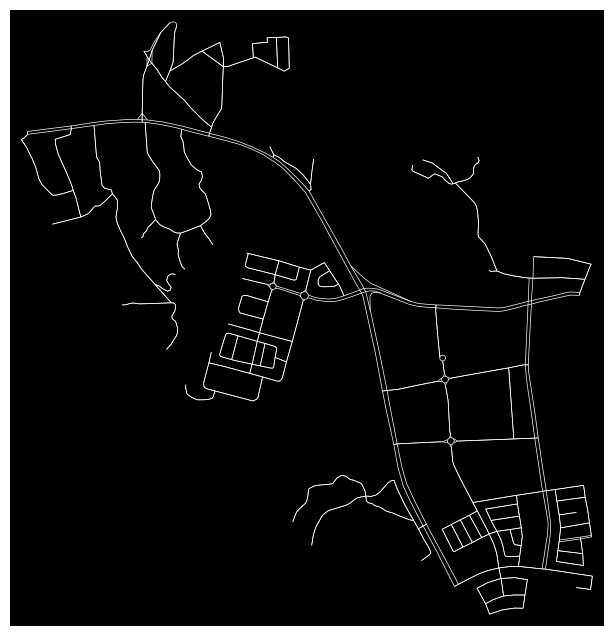

In [ ]:
'''
Visualizing road networks and evaluating accessibility
'''

import networkx as nx

# Visualize road networks (skip if there is no valid road network)
if road_networks:
    fig, ax = ox.plot_graph(road_networks[0], node_size=0, bgcolor='k', edge_color='w', edge_linewidth=0.5)
else:
    print("There's no valid network. Skip the visualization.")

# Evaluate accessibility: Calculate the average distance from each cluster centroid to the main road nodes
accessibility_scores = []
for i, G in enumerate(road_networks):
    try:
        center_node = ox.distance.nearest_nodes(G, cluster_centers[i][0], cluster_centers[i][1])

        # networkx's shortest_path_length 
        lengths = nx.single_source_dijkstra_path_length(G, center_node, weight='length')

        # Use the average distance as an accessibility metric
        mean_distance = np.mean(list(lengths.values()))
        accessibility_scores.append(mean_distance)
    except Exception as e:
        print(f"Error in evaluating accessibility: {e}. Skip cluster {i+1}'s accessibility evaluation.")
        accessibility_scores.append(float('inf'))  

최적의 물류센터 위치는 클러스터 2의 중심점입니다.
최적 위치 좌표: X좌표 = 128.18263091269648, Y좌표 = 37.134549694830596


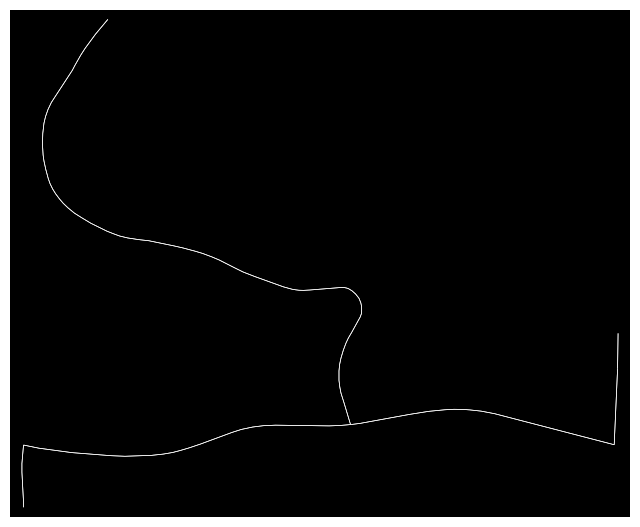

In [ ]:
'''
Recommend the optimal logistics center location based on accessibility evaluation
'''

# Select the cluster centroid with the best accessibility score as the optimal location
if accessibility_scores:
    best_cluster_idx = np.argmin(accessibility_scores)
    best_location = cluster_centers[best_cluster_idx]
    print(f"Optimal logistics center location is the centroid of cluster {best_cluster_idx+1}.")
    print(f"Optimal location coordinates: X = {best_location[0]}, Y = {best_location[1]}")


    # Visualize the optimal location
    if road_networks[best_cluster_idx]:
        fig, ax = ox.plot_graph(road_networks[best_cluster_idx], node_size=0, bgcolor='k', edge_color='w', edge_linewidth=0.5)
else:
    print("There is no valid accessibility evaluation, so we cannot recommend the optimal location.")

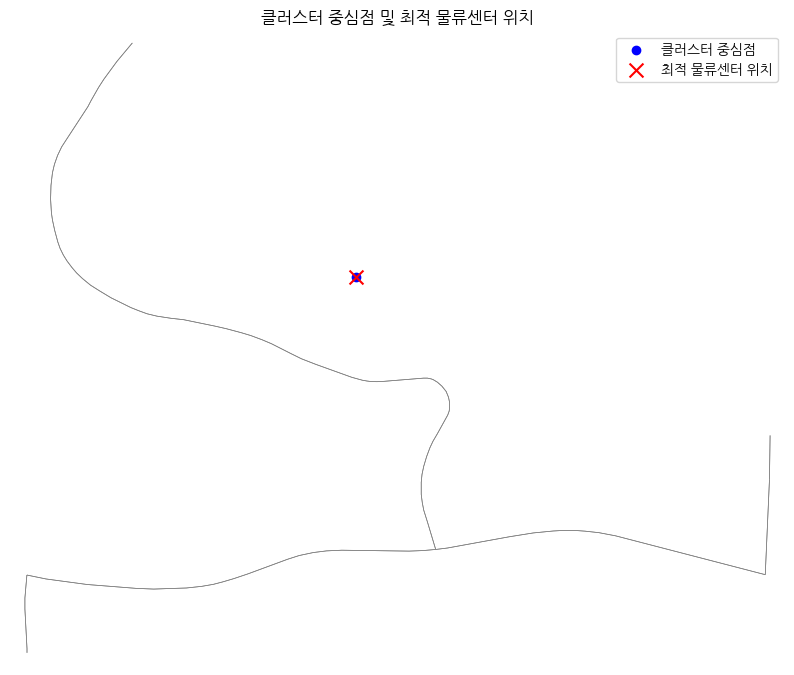

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox

# Use Geopandas to convert coordinate data to GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in cluster_centers]
gdf_clusters = gpd.GeoDataFrame(geometry=geometry)

# Emphasize the optimal location (specify a different color)
best_location_point = Point(best_location[0], best_location[1])
gdf_best_location = gpd.GeoDataFrame(geometry=[best_location_point])

# Visualize the cluster centroids and the optimal location
fig, ax = plt.subplots(figsize=(10, 10))

# Visualize the cluster centroids
gdf_clusters.plot(ax=ax, color='blue', marker='o', label='클러스터 중심점')

# Visualize the optimal location (emphasize with a different color)
gdf_best_location.plot(ax=ax, color='red', marker='x', markersize=100, label='최적 물류센터 위치')

# Visualize the road network (show the main road nodes)
ox.plot_graph(road_networks[best_cluster_idx], ax=ax, node_size=0, edge_color='gray', edge_linewidth=0.5, show=False, close=False)

# Add title and legend
plt.title('Center of Clusters and Optimal Logistics Center Location')
plt.legend()
plt.show()